# Example plotting of CESM-LE

In [1]:
%matplotlib inline
import os

from glob import glob

import cftime

import numpy as np
import xarray as xr

In [2]:
from ncar_jobqueue import NCARCluster
cluster = NCARCluster()
cluster.scale(36) #adapt(minimum_jobs=1, maximum_jobs=40)
cluster

/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [3]:
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://10.12.205.13:34999 Dashboard: https://jupyterhub.ucar.edu/dav/user/mclong/proxy/35012/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## read some CESM-LE data

In [4]:
cesmle_root = '/glade/p/cesm/community/CESM-LE/data/CESM-CAM5-BGC-LE'

component = 'ocn'
freq = 'monthly'
stream = 'pop.h' # POP ocean model monthly stream
case = 'b.e11.B20TRC5CNBDRD.f09_g16.001'

variables = ['SST', 'diatChl']
grid_vars = ['KMT', 'TAREA', 'TLAT', 'TLONG', 'z_t', 'dz', 'z_t_150m', 'time', 'time_bound']

# loop over variables, construct list of datasets
ds_list = []
for v in variables:
    files = glob(f'{cesmle_root}/{component}/proc/tseries/{freq}/{v}/{case}.{stream}.{v}.*.nc')
    dsi = xr.open_mfdataset(files, decode_coords=False, decode_times=False, 
                            concat_dim='time',
                            combine='nested',
                            data_vars=[v],
                            chunks={'nlon': 16})
    # SST has a singleton z_t dimension, so remove this to avoid problems on merge
    if v == 'SST':
        dsi = dsi.squeeze(dim='z_t', drop=True).drop('dz')
        
        
    ds_list.append(dsi)
    
ds = xr.merge(ds_list)
ds = ds[variables+grid_vars]

ds['time'] = xr.DataArray(cftime.num2date(ds.time_bound.mean(dim='d2'), units=ds.time.units, 
                                         calendar=ds.time.calendar), dims=('time'))

ds

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1872, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * time        (time) object 1850-01-17 00:30:00 ... 2005-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    SST         (time, nlat, nlon) float32 dask.array<shape=(1872, 384, 320), chunksize=(1872, 384, 16)>
    diatChl     (time, z_t_150m, nlat, nlon) float32 dask.array<shape=(1872, 15, 384, 320), chunksize=(1872, 15, 384, 16)>
    KMT         (nlat, nlon) float64 dask.array<shape=(384, 320), chunksize=(384, 16)>
    TAREA       (nlat, nlon) float64 dask.array<shape=(384, 320), chunksize=(384, 16)>
    TLAT        (nlat, nlon) float64 dask.array<shape=(384, 320), chunksize=(384, 16)>
    TLONG       (nlat, nlon) float64 dask.array<shape=(384, 320), chunksize=(384, 16)>
    dz          (z_t) float32

## Compute monthly climatology over 1986-2005

Subset data in time and apply climatological averaging.

In [5]:
%%time
#ds = ds.sel(time=slice('1986-01-01', '2005-12-31'))

# compute climatology only on variables with 'time' dimension
ds_clim = ds[variables].isel(time=slice(1632, 1872)).groupby('time.month').mean('time')

# add back grid variables 
for v in grid_vars:
    if 'time' not in v:
        ds_clim[v] = ds[v]

ds_clim = ds_clim.compute()
ds_clim

CPU times: user 1.64 s, sys: 345 ms, total: 1.99 s
Wall time: 10.1 s


<xarray.Dataset>
Dimensions:   (month: 12, nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t_150m  (z_t_150m) float32 500.0 1500.0 2500.0 ... 12500.0 13500.0 14500.0
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * z_t       (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    SST       (month, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    diatChl   (month, z_t_150m, nlat, nlon) float32 nan nan nan ... nan nan nan
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    dz        (z_t) float32 1000.0 1000.0 1000.0 ... 24996.244 24998.11

Example quick-look global plot.

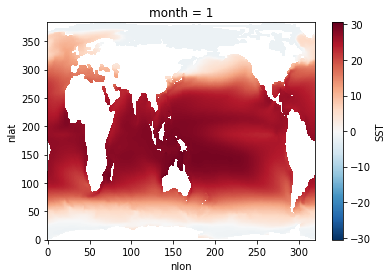

In [6]:
ds_clim.SST.sel(month=1).plot()

Simple Hovmoller plot

/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


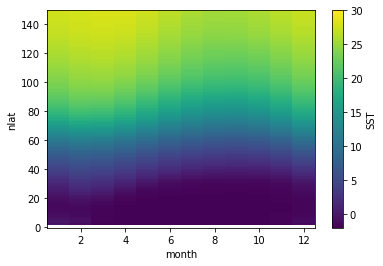

In [7]:
ds_clim.SST.isel(nlat=slice(0, 150)).mean(dim='nlon').T.plot(vmin=-2, vmax=30)

## visualize land mask

`KMT` is the `k` index of the models lowest level. We can use this variable to visualize the land mask.

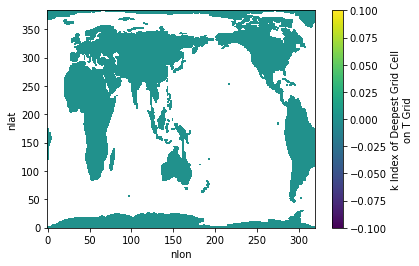

In [8]:
ds.KMT.where(ds.KMT==0).plot()

## take a peak at SST variable

In [9]:
ds.SST

<xarray.DataArray 'SST' (time: 1872, nlat: 384, nlon: 320)>
dask.array<shape=(1872, 384, 320), dtype=float32, chunksize=(1872, 384, 16)>
Coordinates:
  * time     (time) object 1850-01-17 00:30:00 ... 2005-12-16 12:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    coordinates:   TLONG TLAT z_t time
    grid_loc:      3111
    cell_methods:  time: mean

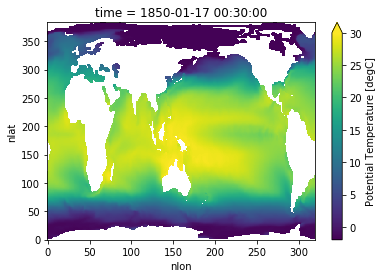

In [10]:
ds.SST.isel(time=0).plot(vmin=-2, vmax=30)

Let's compute the area-weight mean SST in the Southern Ocean.
First we need the cell-area:

In [11]:
ds.TAREA

<xarray.DataArray 'TAREA' (nlat: 384, nlon: 320)>
dask.array<shape=(384, 320), dtype=float64, chunksize=(384, 16)>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:    area of T cells
    units:        centimeter^2
    coordinates:  TLONG TLAT

Construct a mask

In [12]:
masked_area = ds.TAREA.where((ds.TLAT <= -45) & (ds.KMT > 0))
masked_area

<xarray.DataArray 'TAREA' (nlat: 384, nlon: 320)>
dask.array<shape=(384, 320), dtype=float64, chunksize=(384, 16)>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:    area of T cells
    units:        centimeter^2
    coordinates:  TLONG TLAT

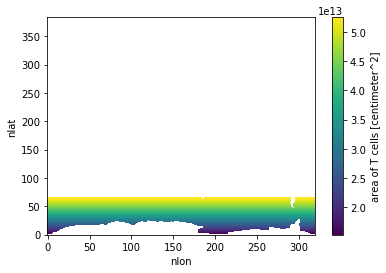

In [13]:
masked_area.plot()

In [14]:
sst_so_mean = (ds.SST * masked_area).sum(['nlat', 'nlon']) / masked_area.sum(['nlat', 'nlon'])
sst_so_mean = sst_so_mean.compute()
sst_so_mean

<xarray.DataArray (time: 1872)>
array([4.609919, 5.200712, 5.004484, ..., 2.392213, 2.976475, 4.138765])
Coordinates:
  * time     (time) object 1850-01-17 00:30:00 ... 2005-12-16 12:00:00

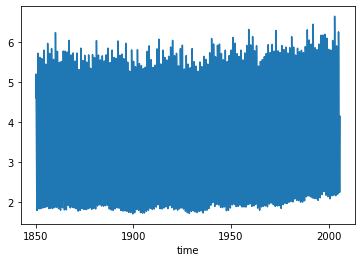

In [15]:
sst_so_mean.plot()

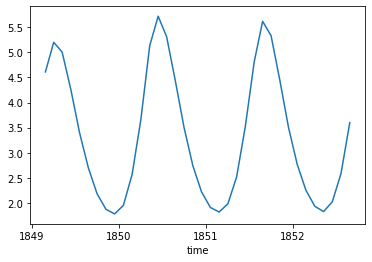

In [16]:
sst_so_mean.isel(time=slice(0, 36)).plot()

In [17]:
diatChl_so_mean = (ds.diatChl.isel(z_t_150m=0) * masked_area).sum(['nlat', 'nlon']) / masked_area.sum(['nlat', 'nlon'])
diatChl_so_mean = diatChl_so_mean.compute()
diatChl_so_mean

<xarray.DataArray (time: 1872)>
array([0.607599, 0.428859, 0.249242, ..., 0.127524, 0.26819 , 0.678102])
Coordinates:
    z_t_150m  float32 500.0
  * time      (time) object 1850-01-17 00:30:00 ... 2005-12-16 12:00:00

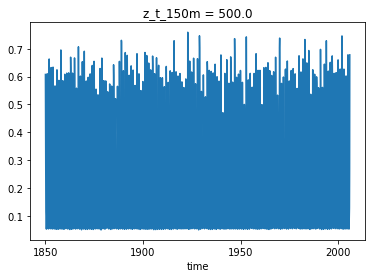

In [18]:
diatChl_so_mean.plot()

In [19]:
cluster.close()
client.close()